In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1602615539397_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT
#Careful not to get SSC for SC
#PM, SC - 
#PM, SSC - DONT WANT
#PM, SC, SSC
#18 labels total - not including PM (doesn't yet include NOLABEL label - 19 labels with that)
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'PII') then 1 else 0 end as PII, \
case when contains(r.observations, 'PR') then 1 else 0 end as PR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS, \
case when contains(r.observations, 'DC') then 1 else 0 end as DC, \
case when contains(r.observations, 'CR') then 1 else 0 end as CR, \
case when contains(r.observations, 'FRD') then 1 else 0 end as FRD, \
case when contains(r.observations, 'TST') then 1 else 0 end as TST, \
case when contains(r.observations, 'CC') then 1 else 0 end as CC, \
case when contains(r.observations, ',SC') then 1 else 0 end as SC, \
case when contains(r.observations, 'PIM') then 1 else 0 end as PIM, \
case when contains(r.observations, 'LC') then 1 else 0 end as LC, \
case when contains(r.observations, 'WEB') then 1 else 0 end as WEB, \
case when contains(r.observations, 'FL') then 1 else 0 end as FL, \
case when contains(r.observations, 'SA') then 1 else 0 end as SA, \
case when contains(r.observations, 'URL') then 1 else 0 end as URL, \
case when contains(r.observations, 'CV') then 1 else 0 end as CV, \
case when contains(r.observations, 'US') then 1 else 0 end as US \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-01-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

#PULLING IN ALL REVIEWS SINCE '2018-10-01' (64,908,446) TAKES ~15 MINS

#PULLING IN ALL REVIEWS SINCE '2020-01-01' (30,174,364) TAKES ~15 MINS (Not any shorter?)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID         CREATED_DATE  ... CV US
0   292594820  2018-07-14 00:00:00  ...  0  0
1   292599288  2019-11-24 00:00:00  ...  0  0
2   304831145  2018-12-03 11:37:34  ...  0  0
3   273217645  2020-04-22 10:32:41  ...  0  0
4   264497280  2020-01-05 04:52:03  ...  0  0
..        ...                  ...  ... .. ..
95  290294707  2018-09-12 00:00:00  ...  0  0
96  290474770  2018-08-13 00:00:00  ...  0  0
97  292003415  2020-08-16 08:23:57  ...  0  0
98  289753709  2019-10-31 00:00:00  ...  0  0
99  291552858  2020-06-08 17:00:00  ...  0  0

[100 rows x 27 columns]

In [7]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30174364 entries, 0 to 30174363
Data columns (total 27 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   UGC_ID             int64 
 1   CREATED_DATE       object
 2   REVIEW_HEADLINE    object
 3   REVIEW_COMMENTS    object
 4   REVIEW_RATING      int64 
 5   REVIEWER_NICKNAME  object
 6   REVIEWER_LOCATION  object
 7   OBSERVATIONS       object
 8   PM                 int64 
 9   NR                 int64 
 10  PII                int64 
 11  PR                 int64 
 12  CS                 int64 
 13  DC                 int64 
 14  CR                 int64 
 15  FRD                int64 
 16  TST                int64 
 17  CC                 int64 
 18  SC                 int64 
 19  PIM                int64 
 20  LC                 int64 
 21  WEB                int64 
 22  FL                 int64 
 23  SA                 int64 
 24  URL                int64 
 25  CV                 int64 
 26  US          

In [8]:
#reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
#reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))

#df.loc[df['set_of_numbers'] <= 4, 'equal_or_lower_than_4?'] = 'True' 
#reviews.loc[reviews['NOLABEL'] == 0, 'TEST'] = 1
#df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
#reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
#reviews = reviews2
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID                int64
CREATED_DATE         object
REVIEW_HEADLINE      object
REVIEW_COMMENTS      object
REVIEW_RATING         int64
REVIEWER_NICKNAME    object
REVIEWER_LOCATION    object
OBSERVATIONS         object
PM                    int64
NR                    int64
PII                   int64
PR                    int64
CS                    int64
DC                    int64
CR                    int64
FRD                   int64
TST                   int64
CC                    int64
SC                    int64
PIM                   int64
LC                    int64
WEB                   int64
FL                    int64
SA                    int64
URL                   int64
CV                    int64
US                    int64
dtype: object

In [14]:
#reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
#        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID         CREATED_DATE                           REVIEW_HEADLINE  \
0   292594820  2018-07-14 00:00:00  Review title not submitted by reviewer.    
1   292599288  2019-11-24 00:00:00  Review title not submitted by reviewer..   
2   304831145  2018-12-03 11:37:34  Very comfortable and breathable            
3   273217645  2020-04-22 10:32:41  Perfect side table                         
4   264497280  2020-01-05 04:52:03  I would buy this t-shirt                   
..        ...                  ...                       ...                   
95  290294707  2018-09-12 00:00:00  Not submitted by reviewer.                 
96  290474770  2018-08-13 00:00:00  Great Addition to College Clothes          
97  292003415  2020-08-16 08:23:57  Yes                                        
98  289753709  2019-10-31 00:00:00  Really cute skirt!!                        
99  291552858  2020-06-08 17:00:00  Review title not submitted by reviewer.    

                                       

In [15]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64 
CREATED_DATE         object
REVIEW_HEADLINE      object
REVIEW_COMMENTS      object
REVIEW_RATING        int64 
REVIEWER_NICKNAME    object
REVIEWER_LOCATION    object
OBSERVATIONS         object
PM                   int64 
NR                   int64 
PII                  int64 
PR                   int64 
CS                   int64 
DC                   int64 
CR                   int64 
FRD                  int64 
TST                  int64 
CC                   int64 
SC                   int64 
PIM                  int64 
LC                   int64 
WEB                  int64 
FL                   int64 
SA                   int64 
URL                  int64 
CV                   int64 
US                   int64 
ALL_TEXT             object
dtype: object

In [16]:


#reviews['PRICE'] = bool(re.match('location', str(reviews['ALL_TEXT'])))
#reviews[reviews['PRICE']==True].head()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
X = reviews[['ALL_TEXT','REVIEW_RATING']]
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                   ALL_TEXT  \
0         headline Review title not submitted by reviewer. comment See other reviews for more detailed feedback.                                                                                                                                                                                                                                                                              
1         headline Review title not submitted by reviewer.. comment These are my new "go to" earrings for events I'm attending!  They're so elegant & pretty!!                                                                            

In [18]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          NR
0         0 
1         0 
2         0 
3         0 
4         0 
...      .. 
30174359  0 
30174360  0 
30174361  0 
30174362  0 
30174363  0 

[30174364 rows x 1 columns]

In [19]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    230323
dtype: int64

In [20]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                             ALL_TEXT  \
20561368  headline Very Good paint that is thick and dry to help with landscape comment I found the paint very good to use in landscape painting especially for snow when needing that "breaking effect" Bob Ross often spoke of. The paint is consistent throughout the tube and works great with blending other colors also.                                                                          
29527414  headline Perfect cold brew! comment Best cold brew out there. I've tried many. Taste is sweet without the sugar. Flavor is amazing. Super easy to make. No more coffee grind mess.                          

In [55]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(ngram_range = (2,2), max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))
#25 mins for 65 mil rows
#16 mins for 30 mil rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
#print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(24139491,1)
#print(ratings_vector_xtrain)
ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(6034873,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
#Combine TF-IDF and ratings vectors
xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = OneVsRestClassifier(lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
#Train model
clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [62]:
np.any(np.isnan(xtrain_final))
#np.any(np.isnan(tfidf_vectors_xtrain))
#np.any(np.isnan(ratings_vector_xtrain))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Traceback (most recent call last):
TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''



In [63]:
np.all(np.isfinite(xtrain_final))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Traceback (most recent call last):
TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''



In [64]:
#pd.isnull(xtrain_final).values.any()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
#ytrain.dtypes
#NO US LABEL
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    184258
dtype: int64

In [66]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
%matplotlib inline

In [69]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

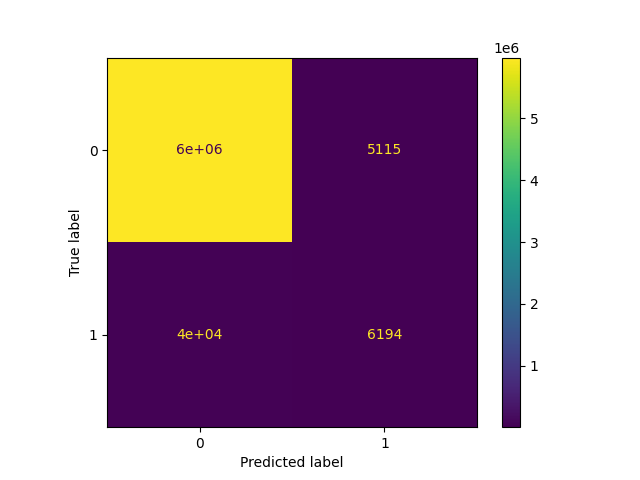

In [70]:
%matplot plt

In [71]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.9925456592044274
Precision is:  0.5477053674064905
Recall is:  0.13446217301638988
F1 Score is:  0.2159166172830899

In [73]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   5988808
           1       0.55      0.13      0.22     46065

    accuracy                           0.99   6034873
   macro avg       0.77      0.57      0.61   6034873
weighted avg       0.99      0.99      0.99   6034873

In [74]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'numpy.float64' object is not callable
Traceback (most recent call last):
TypeError: 'numpy.float64' object is not callable



In [75]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

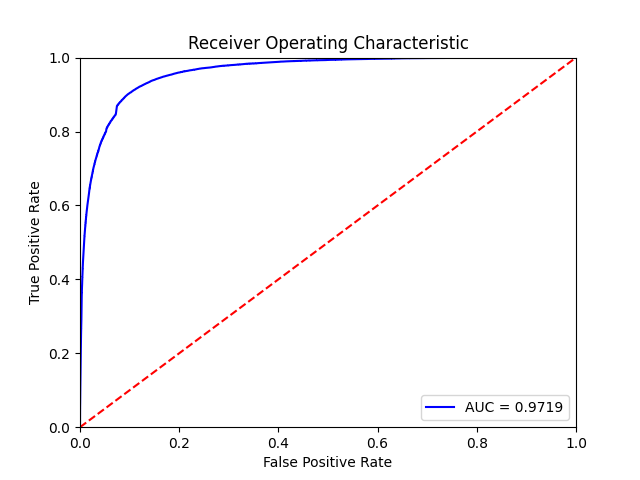

In [77]:
%matplot plt

In [78]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.009341041079284683
Optimal tpr value: 0.90057527406925
Optimal fpr value: 0.09617489824352358

In [79]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.9038002953831837
Precision is:  0.06718675602227196
Recall is:  0.90057527406925
F1 Score is:  0.12504464803782236

In [81]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6034873

In [82]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
auc = auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'numpy.float64' object is not callable
Traceback (most recent call last):
TypeError: 'numpy.float64' object is not callable



In [83]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

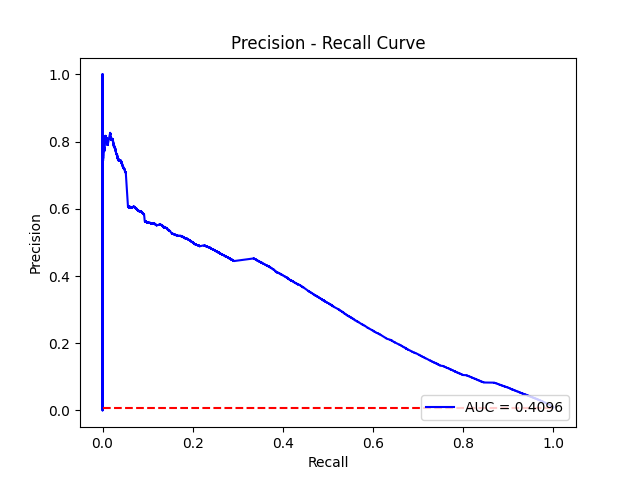

In [85]:
%matplot plt

In [86]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.964509, F-Score=nan
Recall=0.000000
Precision=0.000000
<string>:3: RuntimeWarning: invalid value encountered in true_divide

In [87]:
#LOGISTIC REGRESSION - solver default=’lbfgs’

#Only comments and headline - not location and nickname
#Single tokens
#data set = 64,908,446
#max_features = 50000
#ERRORS WITH: (but don't see any missing values so not sure, memory issue?)
#Input contains NaN, infinity or a value too large for dtype('float64').

#Only comments and headline - not location and nickname
#Single tokens
#data set = 30 mil
#max_features = 30000
#Best Threshold=0.245491, F-Score=0.457
#Recall=0.445479
#Precision=0.468923

#Only comments and headline - not location and nickname
#n-gram
#data set = 30 mil
#max_features = 30000
#Errors
#Best Threshold=0.964509, F-Score=nan
#Recall=0.000000
#Precision=0.000000
#<string>:3: RuntimeWarning: invalid value encountered in true_divide

#Single tokens
#data set = 500,000
#max_features = 30000
#Best Threshold=0.209417, F-Score=0.498
#Recall 0.49516908212560384
#Precision 0.5012224938875306


#Single tokens
#data set = 500,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#Single tokens
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.200349, F-Score=0.499
#Recall=0.504227
#Precision=0.494083

#Only comments and headline - not location and nickname
#Single tokens
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.257027, F-Score=0.500
#Recall=0.481944
#Precision=0.519679


#2 n-grams
#data set = 5,000,000
#max_features = 50000
#Best Threshold=0.221356, F-Score=0.484
#Recall=0.471806
#Precision=0.495870

#3 n-grams
#data set = 5,000,000
#max_features = 50000 or 30000
#BOTH MAX FEATURE SIZES GIVE MEMORY ERROR

#Word embeddings
#data set = 500,000
#Best Threshold=0.228202, F-Score=0.471
#Recall=0.454545
#Precision=0.488506

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…